In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.listdir('/kaggle/input/clothing-classification')

['jeans (3)',
 'shoes',
 'shorts',
 'dress (2)',
 'trousers (2)',
 'suit',
 'summerwear',
 't-shirt (1)',
 'skirt',
 'shirt (2)']

In [3]:
!rm -rf /kaggle/working/*

In [4]:
import albumentations as A
import cv2
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# --- Set Random Seed for Reproducibility ---
random.seed(42)
TEST_SIZE = 0.15  # 15% for testing
VAL_SIZE = 0.15  # 15% for validation
# --- Define Paths ---
original_dataset_path = r"/kaggle/input/clothing-classification"  # Path to original dataset
augmented_dataset_path = r"/kaggle/working/"  # New dataset folder
train_dir, val_dir, test_dir = [os.path.join(augmented_dataset_path, x) for x in ["train", "val", "test"]]

# Function to get deepest-level category directories
def get_deepest_categories(base_path):
    categories = []
    for root, dirs, files in os.walk(base_path):
        if not dirs:  # No subdirectories, meaning it's the deepest level
            category_name = os.path.basename(root)
            categories.append((category_name, root))
    return categories

categories = get_deepest_categories(original_dataset_path)

for folder in [augmented_dataset_path, train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# --- Step 1: Split Dataset ---
category_splits = {}
print(categories)
for category, category_path in categories:
    images = os.listdir(category_path)
    random.shuffle(images)

    # Perform train-test-validation split
    train_imgs, temp_imgs = train_test_split(images, test_size=(VAL_SIZE + TEST_SIZE), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42)

    category_splits[category] = {
        "train": train_imgs,
        "val": val_imgs,
        "test": test_imgs,
        "path": category_path
    }

    # Create category folders in split directories
    for folder, img_list in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        category_split_path = os.path.join(folder, category)
        os.makedirs(category_split_path, exist_ok=True)
        
        for img in img_list:
            shutil.copy(os.path.join(category_path, img), os.path.join(category_split_path, img))

    print(f"Category: {category} -> Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

[('jeans', '/kaggle/input/clothing-classification/jeans (3)/kaggle/working/data/jeans'), ('shoes', '/kaggle/input/clothing-classification/shoes/kaggle/working/data/shoes'), ('shorts', '/kaggle/input/clothing-classification/shorts/kaggle/working/data/shorts'), ('dress', '/kaggle/input/clothing-classification/dress (2)/kaggle/working/data/dress'), ('trousers', '/kaggle/input/clothing-classification/trousers (2)/kaggle/working/data/trousers'), ('suit', '/kaggle/input/clothing-classification/suit/kaggle/working/data/suit'), ('summerwear', '/kaggle/input/clothing-classification/summerwear/kaggle/working/data/summerwear'), ('t-shirt', '/kaggle/input/clothing-classification/t-shirt (1)/kaggle/working/data/t-shirt'), ('skirt', '/kaggle/input/clothing-classification/skirt/kaggle/working/data/skirt'), ('shirt', '/kaggle/input/clothing-classification/shirt (2)/kaggle/working/data/shirt')]
Category: jeans -> Train: 564, Val: 121, Test: 122
Category: shoes -> Train: 6839, Val: 1466, Test: 1466
Cate

In [5]:
print('wait')

wait


# Model Building

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import Xception,EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Set Paths ---
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

# --- Load Data Using tf.keras.utils.image_dataset_from_directory() ---
BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='int',
    seed=42,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='int',
    seed=42,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='int',
    seed=42,
    shuffle=False
)

# Extract labels from the entire training dataset (not validation)
all_labels = []
for _, labels in train_dataset:  # Use train dataset to compute class weights
    all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)  # Convert to numpy array

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)

# Convert to dictionary format for model training
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Computed Class Weights:", class_weights_dict)


Found 38646 files belonging to 10 classes.
Found 8283 files belonging to 10 classes.
Found 8286 files belonging to 10 classes.
Computed Class Weights: {0: 0.475994580613376, 1: 6.852127659574468, 2: 1.535399284862932, 3: 0.5650826144173124, 4: 0.8567058301928618, 5: 1.3073748308525033, 6: 6.029017160686427, 7: 3.608403361344538, 8: 0.6832743988684583, 9: 0.6695426195426195}


In [5]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
def create_model(image_height, image_width, cost_function):
    inputs = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)  # Keep only rescaling (no augmentation)
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False  # Freeze the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(len(train_dataset.class_names), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate = 0.0001), 
                  metrics=[cost_function])
    return model

model = create_model(299, 299, 'accuracy')
# --- Define Callbacks to Prevent Overfitting ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),  # Stops training if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),  # Reduces learning rate when loss stagnates
    # ModelCheckpoint("correct_best_xception_model.keras", save_best_only=True, monitor='val_loss', verbose=1)  # Saves best model
]
print(model.summary())
# --- Train Model and Store History ---
history = model.fit(
    train_dataset.prefetch(tf.data.AUTOTUNE), 
    validation_data=val_dataset.prefetch(tf.data.AUTOTUNE), 
    epochs=20,  
    callbacks=callbacks,
    class_weight = class_weights_dict
)

# --- Save Model as .keras File ---
model.save("class_weights_correct_final_xception_model.keras")

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_34 (Rescaling)  │ (None, 299, 299, 3)    │              0 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ rescaling_34[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool          

 Total params: 21,977,522 (83.84 MB)

 Trainable params: 8,442,418 (32.21 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

None
Epoch 1/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 263s 200ms/step - accuracy: 0.7501 - loss: 0.7902 - val_accuracy: 0.9143 - val_loss: 0.2678 - learning_rate: 1.0000e-04
Epoch 2/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 222s 184ms/step - accuracy: 0.9317 - loss: 0.1935 - val_accuracy: 0.9506 - val_loss: 0.1650 - learning_rate: 1.0000e-04
Epoch 3/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 221s 183ms/step - accuracy: 0.9603 - loss: 0.1110 - val_accuracy: 0.9392 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 4/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 244s 201ms/step - accuracy: 0.9735 - loss: 0.0715 - val_accuracy: 0.9577 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 5/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 223s 185ms/step - accuracy: 0.9838 - loss: 0.0422 - val_accuracy: 0.9600 - val_loss: 0.1807 - learning_rate: 1.0000e-04
Epoch 6/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 225s 186ms/step - accuracy: 0.9868 - loss: 0.0370 - val_accuracy: 0.9579 - val_loss: 0.2072 - learning_rate: 1.0000e-04
Epoch 7/20
1208/1208 ━━

In [51]:
# --- Evaluate Model ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='int',
    shuffle = False,
    seed=42
)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # True labels
y_pred_prob = model.predict(test_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

Found 8286 files belonging to 10 classes.
259/259 ━━━━━━━━━━━━━━━━━━━━ 47s 183ms/step - accuracy: 0.9596 - loss: 0.1493
Test Accuracy: 0.9592
259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step


In [52]:
# Compute F1 Score
from sklearn.metrics import f1_score
test_f1 = f1_score(y_true, y_pred, average='macro')  # 'macro' for multi-class
print(f"Test F1-Score: {test_f1:.4f}")

# --- Save Training History for Plotting ---
# import pickle
# with open("model_history.pkl", "wb") as f:
#     pickle.dump(history.history, f)

Test F1-Score: 0.9500


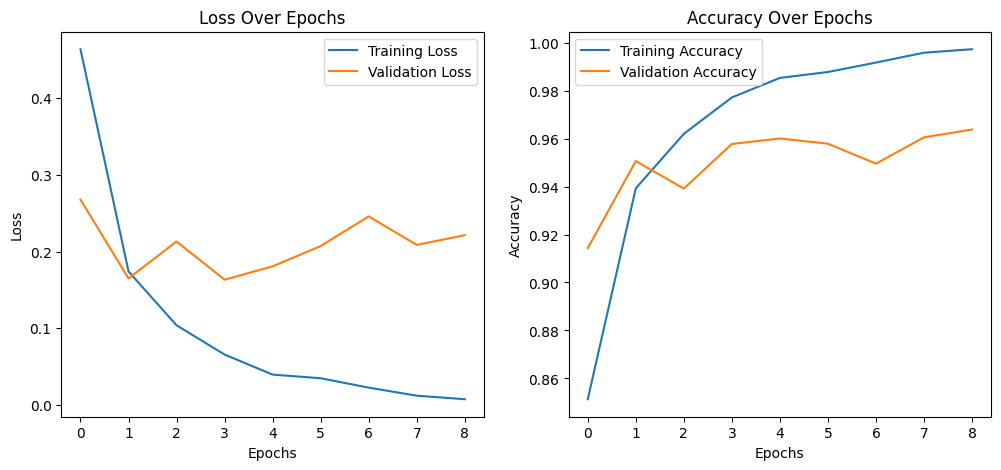

In [53]:
# --- Plot Training History ---
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

# F1-Score Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()

In [56]:
import tensorflow as tf
import json

# Extract class names from dataset
class_names = train_dataset.class_names  # Ensure correct order
print("Class Names:", class_names)

# Save the model
model.save("class_weights_corrected_final_xception_model.keras")

# Save class names separately in a JSON file
with open("class_weights_corrected_final_class_names.json", "w") as f:
    json.dump(class_names, f)  # Save class names separately


Class Names: ['dress', 'jeans', 'shirt', 'shoes', 'shorts', 'skirt', 'suit', 'summerwear', 't-shirt', 'trousers']


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1740
           1       0.92      0.96      0.94       122
           2       0.95      0.99      0.97       540
           3       1.00      1.00      1.00      1466
           4       0.93      0.95      0.94       967
           5       0.88      0.89      0.89       634
           6       0.98      0.99      0.98       138
           7       0.85      0.93      0.89       230
           8       0.98      0.96      0.97      1212
           9       0.96      0.95      0.96      1237

    accuracy                           0.96      8286
   macro avg       0.94      0.96      0.95      8286
weighted avg       0.96      0.96      0.96      8286

